## **Introducing Dynamic Graphs**
- A temporal dimension can be embedded to trasform static graphs into dynamic graphs. These dynamic networks are used as inputs for temporal graph neural networks (T-GNN).
- Dynamic graphs and temporal GNNs unlock a variety of new applications, such as transport and web traffic forecasting, motion classification and epidemiological forecasting.
- Graphs with temporal component can be divided into two categories.
1. Static graphs with temporal signals: The underlying graph does not change, but features and labels change over time.
2. Dynamic graphs with temporal signals: The topology of the graph (presence of nodes and edges), features and labels evolve over time.

## **Forecasting Web Traffic**
- We predict the traffic of Wikipedia articles (as an example of static graph with temporal signal) using a temporal GNN.

#### **Introducing EvolveGCN**
- EvolveGCN proposes a natural combination of GNN and recurrent neural network and the GCN evolves over time to produce relevant temporal node embeddings.
- There are two variants of EvolveGCN. For EvolveGCN-H, the recurrent neural network considers both the previous GCN parameters and the current node embeddings. For EvolveGCN-O, the recurrent neural network only considers the previous GCN parameters.
- EvolveGCN-H uses a GRU instead of a vanilla RNN. GRU updates the GCN’s weight matrix for layer $l$ at time $t$ as follows:
$$W_t^{(l)} = GRU(H_t^{(l)}, W_{t-1}^{(l)})$$

$$H_t^{(l+1)} = GCN(A_t, H_t^{(l)}, W_t^{(l)})$$
- EvolveGCN-O is based on an LSTM network to model the input-output relationship and we do not feed a hidden state to the LSTM.
$$W_t^{(l)} = LSTM(W_{t-1}^{(l)})$$

$$H_t^{(l+1)} = GCN(A_t, H_t^{(l)}, W_t^{(l)})$$
- EvolveGCN-H works better when node features are essential because RNN explicitly incoporates node embeddings. EvolveGCN-O works better when graph structure plays an important role, as it focuses more on topological changes.

#### **Implementing EvolveGCN**
- The WikiMaths dataset is comprised of 1,068 articles represented as nodes. Node features correspond to the past daily number of visits (eight features by default). Edges are weighted, and weights represent the number of links from the source page to the destination page.
- We want to predict the daily user visits to these Wikipedia pages between March 16, 2019, and March 15, 2021, which results in 731 snapshots. Each snapshot is a graph describing the state of the system at a certain time.


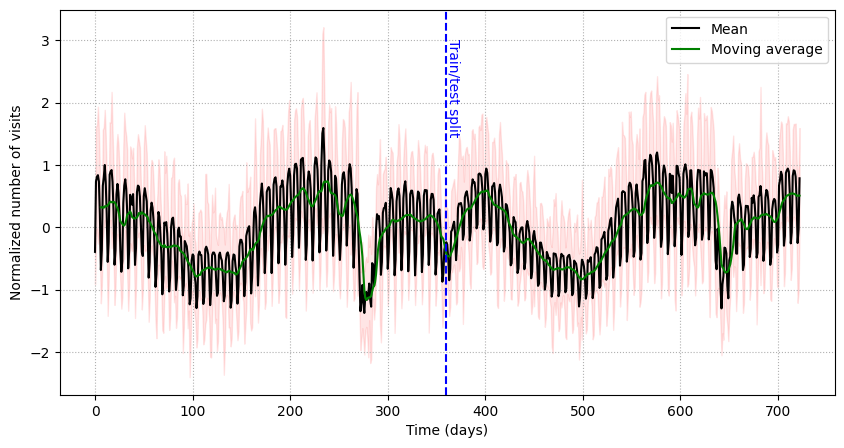

In [4]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# dataset[0] describes the graph at t = 0 and dataset[500] describes the graph at t = 500
# Train-test-split with a ratio of 0.5. Training set compose of snapshots from earlier time periods, test set compose of snapshots from later period.
dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

# Visualise normalized mean and moving average number of visits
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [5]:
import torch
torch.manual_seed(0)

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|██████████| 50/50 [05:28<00:00,  6.56s/it]


MSE = 0.7893


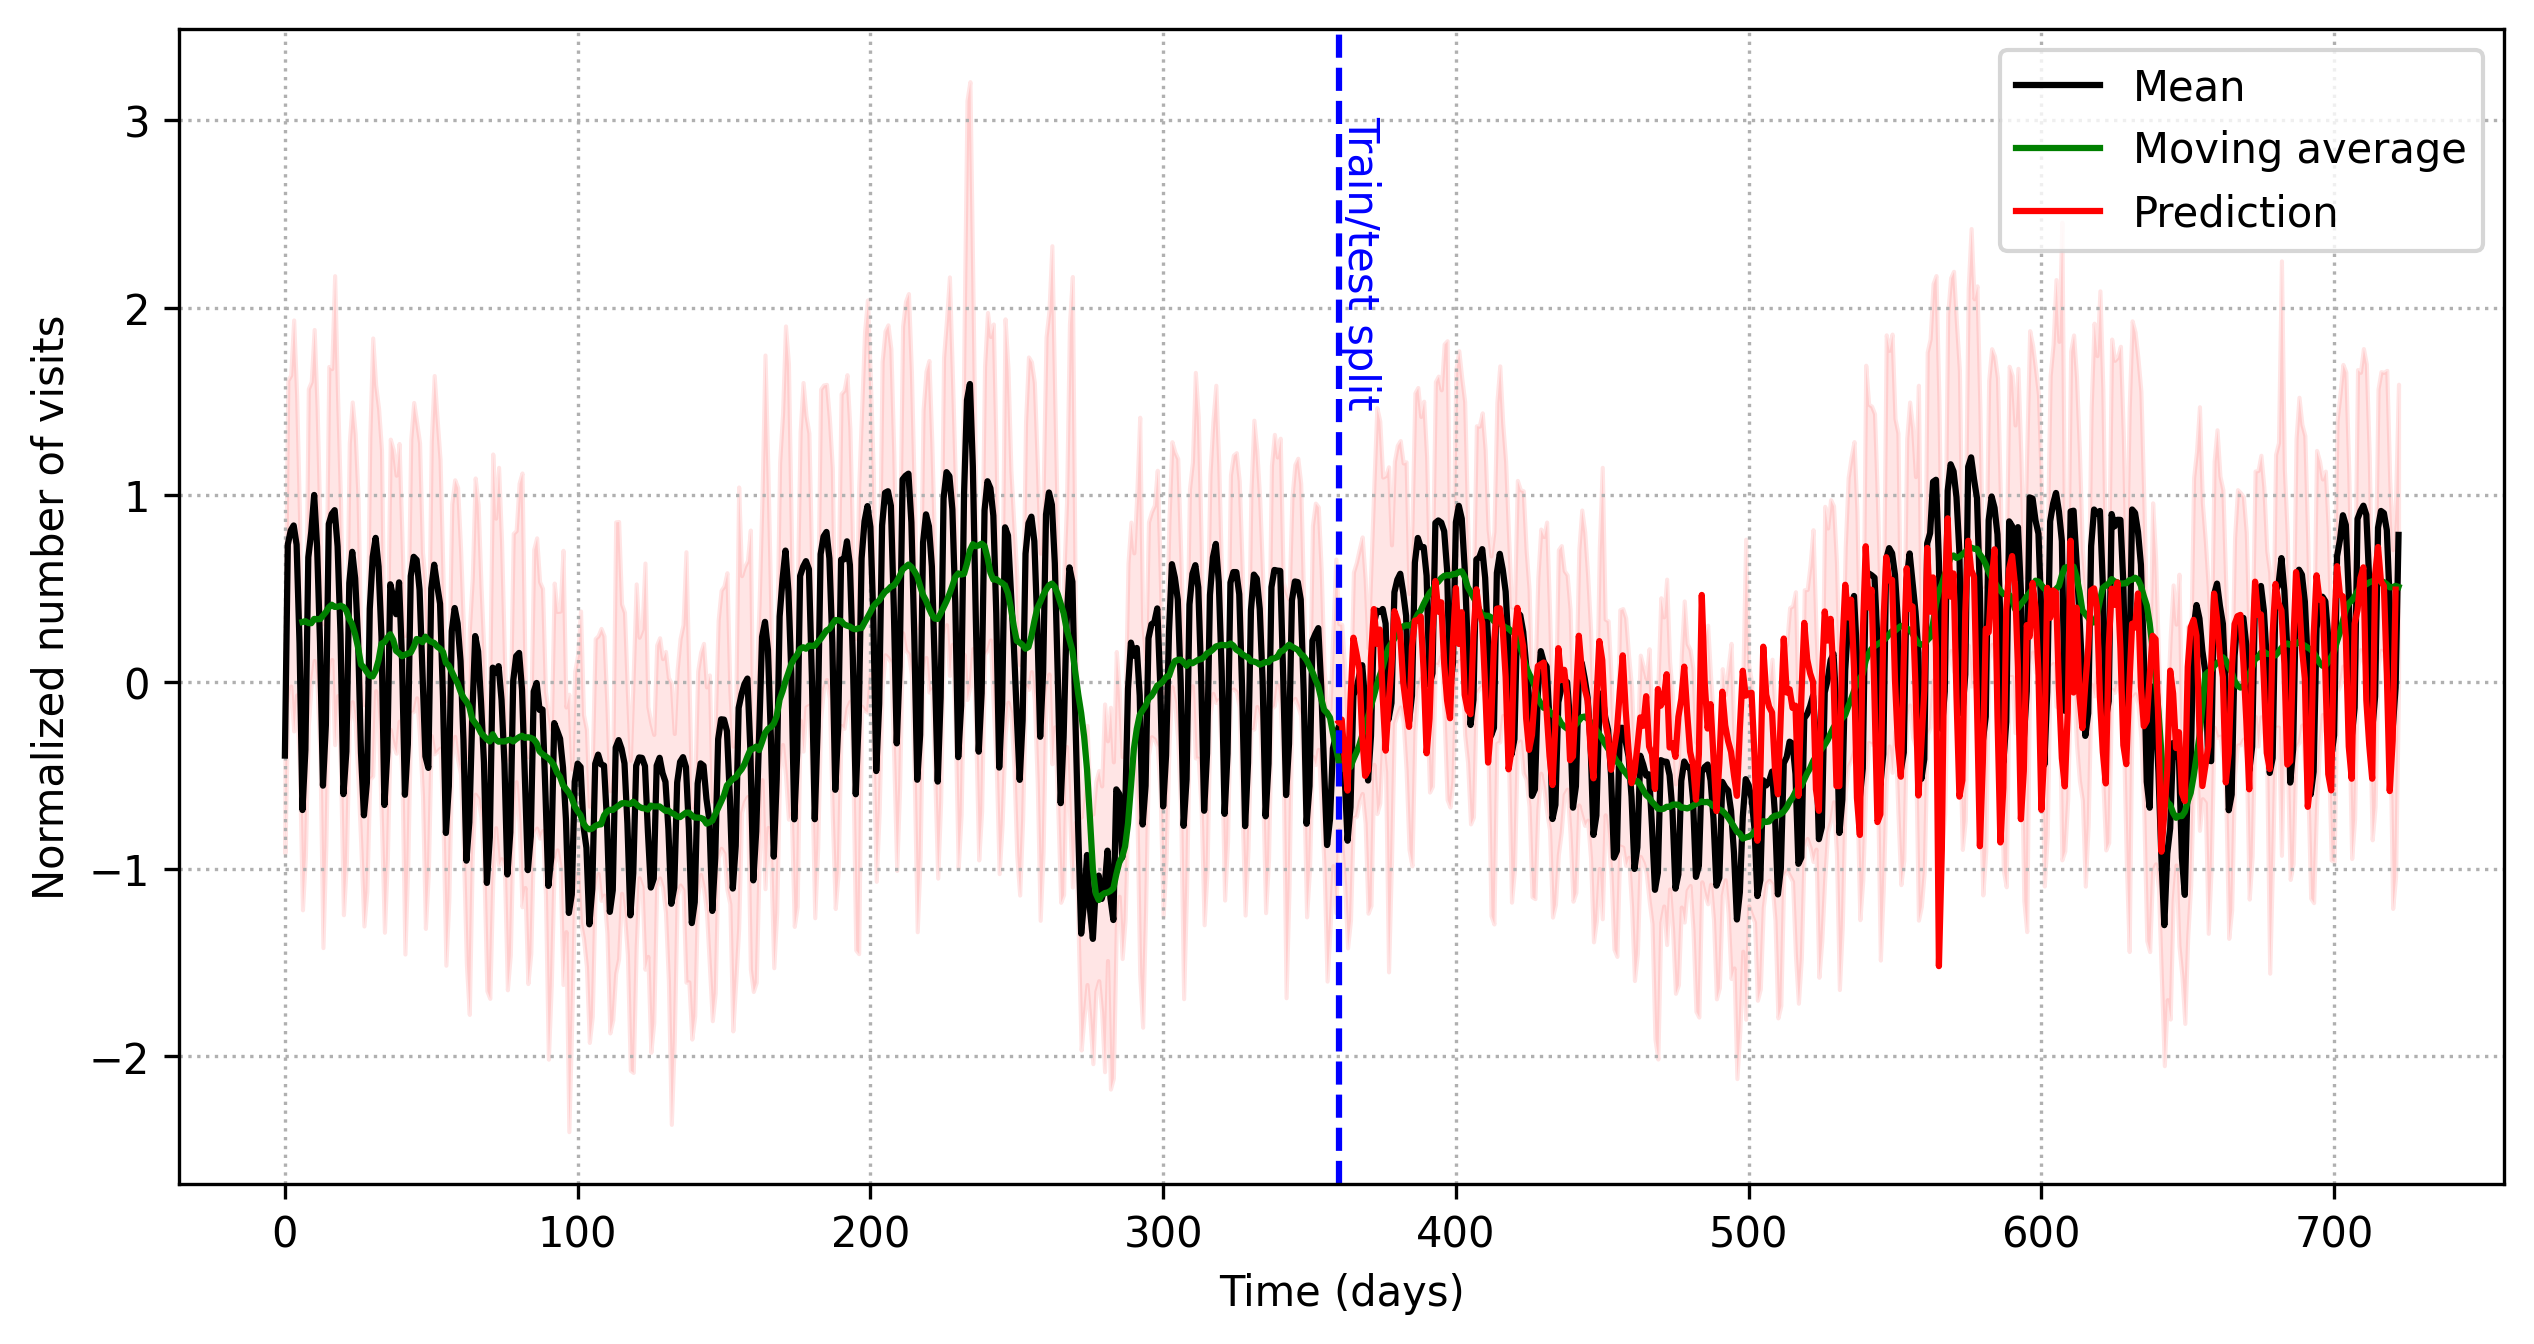

In [6]:
# Visualise average prediction per snapshot with normalised mean and moving average

y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

## **Predict Covid-19 Cases**
- The England Covid dataset represents the number of reported cases of COVID-19 in 129 England NUTS 3 regions between March 3 and May 12, 2020. The goal is to predict the number of cases in each region in 1 day.
- Due to the temporal nature of the dataset, it is composed of multiple graphs corresponding to each day of the studied period $G^{(1)}, \cdots, G^{(T)}$. Node features correspond to the number of cases in the past $d$ days in the region. Edges are unidirectional and weighted. The weight $w_{v,u}^{(t)}$ represents the number of people that moved from region $v$ to region $u$ at time $t$. These graphs also contain self loops corresponding to people moving within the same region.

#### **Introducing MPNN-LSTM**
- The input node features with the corresponding edge indexes and weights are fed to a GCN layer. We apply a batch normalization layer and a dropout to this output. The process is repeated a second time with the outcome of the first MPNN. It produces a node embedding matrix $H^{(t)}$.
- We generate a sequence $H^{(1)}, \cdots, H^{(T)}$ of node embedding representations by applying these MPNN for each time step. This sequence is fed to a 2-layer LSTM network to capture the temporal information from the graphs. Finally, we apply a linear transformation and a ReLU function to this output to produce a prediction at $t+1$.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

# Number of node features = number of lags = 14
# Temporal signal split with training ratio of 0.8
dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# Plot mean normalized number of cases
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

ModuleNotFoundError: No module named 'torch_geometric_temporal'

In [ ]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# Training
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred-snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

In [ ]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')